In [40]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/9d/06/059a7e33548acf6c7bd29f96b2e495571797b4397353bf79631559b97948/wordcloud-1.9.2-cp38-cp38-win_amd64.whl.metadata
   ---------------------------------------- 0.0/153.1 kB ? eta -:--:--
   ------------------------ --------------- 92.2/153.1 kB 1.8 MB/s eta 0:00:01
   ------------------------------------- -- 143.4/153.1 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 153.1/153.1 kB 1.1 MB/s eta 0:00:00


In [63]:
import os
import re
import nltk # работа с пакетами языков
from nltk import word_tokenize, ngrams # токенизация и деление на n граммы
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
import pymorphy2 # работа с русским языком
import string
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\V-C\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\V-C\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
COMMON_DIR = "data"

def read_song(filename):
    #Функция чтения файла
    text = ''
    with open(f'{COMMON_DIR}/{filename}.txt', 'r', encoding='utf-8') as f:
        text = f.read()
        text = text.replace('\n', ' ')
    return text

In [12]:
texts = []

direct_list = os.listdir(COMMON_DIR) # файлы в папке
print(direct_list)

names = [song.replace(".txt", "") for song in direct_list]
print(names)

['Озеро надежды.txt', 'Опять метель.txt', 'русалка.txt', 'Южное солнце твоё север мой обогреет.txt', 'Юрьев день.txt']
['Озеро надежды', 'Опять метель', 'русалка', 'Южное солнце твоё север мой обогреет', 'Юрьев день']


In [13]:
songs_list = []
for song in names:
    songs_list.append(read_song(song)) #чтение данных

songs_list

['Мне влюбиться слишком рано, А быть может, слишком поздно, Никому не верю я, как прежде. Море Счастья обмелело И река Любви замерзла, Но осталось озеро Надежды. Море Счастья обмелело, И река Любви замерзла, Но осталось озеро Надежды.  Припев: Озеро Надежды, все, как есть, прими, Пусть никто не понял - ты меня пойми! Озеро Надежды, имя назови И скажи, куда мне деться от моей любви...  Треснет зеркало в прихожей, На гитаре лопнут струны, Я надену белые одежды. За собой захлопну двери И однажды в полнолунье Я приду на озеро Надежды. За собой захлопну двери, И однажды в полнолунье Я приду на озеро Надежды.  Припев: Озеро Надежды, все, как есть, прими, Пусть никто не понял - ты меня пойми! Озеро Надежды, имя назови И скажи, куда мне деться от моей любви...  Ты прости меня, мой ангел, Что хранил меня напрасно - Не могу я быть такой, как прежде. Скину белые одежды И войду в живую воду, В озеро несбывшейся Надежды.  Припев: Озеро Надежды, все, как есть, прими, Пусть никто не понял - ты меня п

In [21]:
stopwords_list= stopwords.words("russian") #стоп-слова русского языка
len(stopwords_list)

151

In [22]:
def clean_string(text):
    #Функция очищения строк
    string.punctuation += '—'

    text = re.split(' |:|\.|\(|\)|,|"|;|/|\n|\t|-|\?|\[|\]|!', text)
    text = ' '.join([word for word in text if word not in string.punctuation])
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords_list])
    return text

In [24]:
songs_list_сlean = [clean_string(song) for song in songs_list]
songs_list_сlean

['влюбиться слишком рано слишком поздно никому верю прежде море счастья обмелело река любви замерзла осталось озеро надежды море счастья обмелело река любви замерзла осталось озеро надежды припев озеро надежды прими пусть никто понял пойми озеро надежды имя назови скажи деться моей любви треснет зеркало прихожей гитаре лопнут струны надену белые одежды собой захлопну двери однажды полнолунье приду озеро надежды собой захлопну двери однажды полнолунье приду озеро надежды припев озеро надежды прими пусть никто понял пойми озеро надежды имя назови скажи деться моей любви прости ангел хранил напрасно могу прежде скину белые одежды войду живую воду озеро несбывшейся надежды припев озеро надежды прими пусть никто понял пойми озеро надежды имя назови скажи деться моей любви озеро надежды прими пусть никто понял пойми озеро надежды имя назови скажи деться моей любви',
 'тобой закрывая дверь живу который год тех пор отсчёт моих нечаянных потерь остановленный кого ждёт припев метель мается былое

In [30]:
morph = pymorphy2.MorphAnalyzer()

def normilize_word(text):
    # привести слова к начальной форме
    words = text.split() # по пробелу разделить
    result_list = []
    for word in words:
        # print(morph.parse(word))
        normal_form = morph.parse(word)[0].normal_form
        result_list.append(normal_form)
        print(normal_form)
    return " ".join(result_list)


In [31]:
songs_list_norm = [normilize_word(song) for song in songs_list_сlean]
songs_list_norm

влюбиться
слишком
рано
слишком
поздно
никто
верить
прежде
море
счастие
обмелелый
река
любовь
замёрзлый
остаться
озеро
надежда
море
счастие
обмелелый
река
любовь
замёрзлый
остаться
озеро
надежда
припев
озеро
надежда
принять
пусть
никто
понять
понять
озеро
надежда
имя
назвать
сказать
деться
мой
любовь
треснуть
зеркало
прихожая
гитара
лопнуть
струна
надеть
белые
одежда
себя
захлопнуть
дверь
однажды
полнолуние
прийти
озеро
надежда
себя
захлопнуть
дверь
однажды
полнолуние
прийти
озеро
надежда
припев
озеро
надежда
принять
пусть
никто
понять
понять
озеро
надежда
имя
назвать
сказать
деться
мой
любовь
простить
ангел
хранить
напрасно
мочь
прежде
скинуть
белые
одежда
войти
живой
вода
озеро
несбывшийся
надежда
припев
озеро
надежда
принять
пусть
никто
понять
понять
озеро
надежда
имя
назвать
сказать
деться
мой
любовь
озеро
надежда
принять
пусть
никто
понять
понять
озеро
надежда
имя
назвать
сказать
деться
мой
любовь
ты
закрывать
дверь
жить
который
год
тот
пора
отсчёт
мой
нечаянный
потеря
остановить
к

['влюбиться слишком рано слишком поздно никто верить прежде море счастие обмелелый река любовь замёрзлый остаться озеро надежда море счастие обмелелый река любовь замёрзлый остаться озеро надежда припев озеро надежда принять пусть никто понять понять озеро надежда имя назвать сказать деться мой любовь треснуть зеркало прихожая гитара лопнуть струна надеть белые одежда себя захлопнуть дверь однажды полнолуние прийти озеро надежда себя захлопнуть дверь однажды полнолуние прийти озеро надежда припев озеро надежда принять пусть никто понять понять озеро надежда имя назвать сказать деться мой любовь простить ангел хранить напрасно мочь прежде скинуть белые одежда войти живой вода озеро несбывшийся надежда припев озеро надежда принять пусть никто понять понять озеро надежда имя назвать сказать деться мой любовь озеро надежда принять пусть никто понять понять озеро надежда имя назвать сказать деться мой любовь',
 'ты закрывать дверь жить который год тот пора отсчёт мой нечаянный потеря остано

In [36]:
df = pd.DataFrame({'name': names, 'song_text': songs_list_norm})

In [37]:
df.head()

,name,song_text
0,Озеро надежды,влюбиться слишком рано слишком поздно никто ве...
1,Опять метель,ты закрывать дверь жить который год тот пора о...
2,русалка,проходить мимо ходить рядом видеть видеть закр...
3,Южное солнце твоё север мой обогреет,южный солнце твой север обогреть разный судьба...
4,Юрьев день,стоять смотреть ветер рвать венок твой голова ...


In [45]:
plt.rcParams["figure.figsize"] = (10,5) # размер графиков

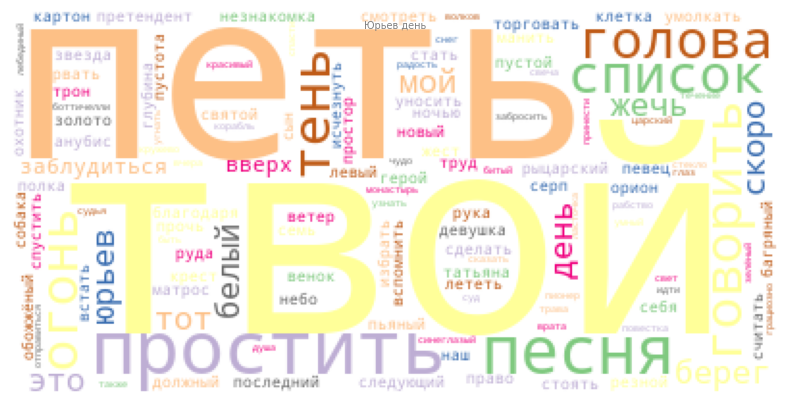

In [54]:
# TODO вынести в def
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.subplots_adjust(wspace=0.3, hspace=0.2)

i = 1

# for name, text in zip(df.name, df.song_text):
#     tokens = word_tokenize(text)
#     text_raw = " ".join(tokens)
#     wordcloud = WordCloud(colormap='PuBu', background_color='white', contour_width=10).generate(text_raw)
#     plt.subplot(4, 3, i, label=name,frame_on=True)
#     plt.tick_params(labelsize=10)
#     plt.imshow(wordcloud)
#     plt.axis("off")
#     plt.title(name,fontdict={'fontsize':7,'color':'grey'},y=0.93)
#     plt.tick_params(labelsize=10)
#     i += 1

# for name, text in zip(df.name, df.song_text):
tokens = word_tokenize(songs_list_norm[4])
text_raw = " ".join(tokens)
wordcloud = WordCloud(colormap='Accent', background_color='white', contour_width=10).generate(text_raw)
# plt.subplot(4, 3, i, label=names[0],frame_on=True)
plt.tick_params(labelsize=10)
plt.imshow(wordcloud)
plt.axis("off")
plt.title(names[4],fontdict={'fontsize':7,'color':'grey'},y=0.93)
plt.tick_params(labelsize=10)
i += 1

In [57]:
# Создание объекта TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Применение TF-IDF к текстовым данным
tfidf_matrix = tfidf_vectorizer.fit_transform(songs_list_norm)

# Получение списка ключевых слов и их значения TF-IDF для первого документа
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()[0]

# Сортировка слов по значениям TF-IDF
sorted_keywords = [word for _, word in sorted(zip(tfidf_scores, feature_names), reverse=True)]

print("Ключевые слова:", sorted_keywords)

Ключевые слова: ['озеро', 'надежда', 'понять', 'никто', 'любовь', 'пусть', 'назвать', 'имя', 'деться', 'принять', 'сказать', 'мой', 'припев', 'слишком', 'река', 'прийти', 'прежде', 'полнолуние', 'однажды', 'одежда', 'обмелелый', 'захлопнуть', 'замёрзлый', 'белые', 'счастие', 'себя', 'остаться', 'море', 'дверь', 'хранить', 'треснуть', 'струна', 'скинуть', 'рано', 'прихожая', 'поздно', 'несбывшийся', 'напрасно', 'надеть', 'мочь', 'лопнуть', 'зеркало', 'живой', 'гитара', 'войти', 'вода', 'влюбиться', 'ангел', 'верить', 'простить', 'ящик', 'юрьев', 'юность', 'южный', 'это', 'шальной', 'чудо', 'чувствовать', 'целый', 'царский', 'хотеть', 'ходить', 'уходить', 'успеть', 'уносить', 'унести', 'умолкать', 'умный', 'узнать', 'узкий', 'угнать', 'увидеться', 'ты', 'труд', 'тропа', 'трон', 'тридцать', 'трава', 'точно', 'тот', 'торговать', 'томиться', 'толкаться', 'течение', 'тень', 'темнота', 'тело', 'твой', 'таять', 'татьяна', 'также', 'тайна', 'сын', 'считать', 'суметь', 'судья', 'судьба', 'суд', 

In [58]:
feature_names

array(['адрес', 'ангел', 'анубис', 'багряный', 'бежать', 'белые', 'белый',
       'берег', 'бережно', 'битый', 'благодаря', 'блаженство',
       'боттичелли', 'бросить', 'былой', 'быстро', 'быть', 'вверх',
       'ведать', 'венок', 'верить', 'весь', 'ветер', 'вечность', 'взгляд',
       'видеть', 'вино', 'влюбиться', 'вновь', 'вода', 'войти', 'волков',
       'враг', 'врата', 'врач', 'время', 'вспомнить', 'встать', 'вчера',
       'гаснуть', 'герой', 'гитара', 'глаз', 'глубина', 'глядеть',
       'гнать', 'говорить', 'год', 'голова', 'гора', 'горсть',
       'грациозно', 'грех', 'губа', 'давность', 'два', 'дверь', 'девушка',
       'день', 'десять', 'деться', 'долго', 'должный', 'дом', 'дорога',
       'друг', 'душа', 'ещё', 'ждать', 'жест', 'жечь', 'живой', 'жизнь',
       'жить', 'заблудиться', 'забросить', 'закрывать', 'закрыть',
       'замёрзлый', 'запомнить', 'захлопнуть', 'звезда', 'зелёный',
       'зеркало', 'зима', 'знать', 'значит', 'золото', 'золотой', 'идти',
       'избра

In [59]:
tfidf_scores

array([0.        , 0.0433582 , 0.        , 0.        , 0.        ,
       0.08671639, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03498112, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0433582 , 0.        , 0.0433582 ,
       0.0433582 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0433582 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05807498, 0.        , 0.        , 0.        ,
       0.17343278, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0433582 , 0.        , 0.        , 0.     

In [65]:

count_vectorizer = CountVectorizer()

bow = count_vectorizer.fit_transform(songs_list_norm)
bow.shape

(5, 330)

In [69]:
import operator
vocab_sorted = sorted(count_vectorizer.vocabulary_.items(), key=operator.itemgetter(0))
vocab_sorted

[('адрес', 0),
 ('ангел', 1),
 ('анубис', 2),
 ('багряный', 3),
 ('бежать', 4),
 ('белые', 5),
 ('белый', 6),
 ('берег', 7),
 ('бережно', 8),
 ('битый', 9),
 ('благодаря', 10),
 ('блаженство', 11),
 ('боттичелли', 12),
 ('бросить', 13),
 ('былой', 14),
 ('быстро', 15),
 ('быть', 16),
 ('вверх', 17),
 ('ведать', 18),
 ('венок', 19),
 ('верить', 20),
 ('весь', 21),
 ('ветер', 22),
 ('вечность', 23),
 ('взгляд', 24),
 ('видеть', 25),
 ('вино', 26),
 ('влюбиться', 27),
 ('вновь', 28),
 ('вода', 29),
 ('войти', 30),
 ('волков', 31),
 ('враг', 32),
 ('врата', 33),
 ('врач', 34),
 ('время', 35),
 ('вспомнить', 36),
 ('встать', 37),
 ('вчера', 38),
 ('гаснуть', 39),
 ('герой', 40),
 ('гитара', 41),
 ('глаз', 42),
 ('глубина', 43),
 ('глядеть', 44),
 ('гнать', 45),
 ('говорить', 46),
 ('год', 47),
 ('голова', 48),
 ('гора', 49),
 ('горсть', 50),
 ('грациозно', 51),
 ('грех', 52),
 ('губа', 53),
 ('давность', 54),
 ('два', 55),
 ('дверь', 56),
 ('девушка', 57),
 ('день', 58),
 ('десять', 59),
 (